[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vrra/FGAN-Build-a-thon-2022/blob/main/Notebooks2022/build_a_thon_graph_v1.ipynb)

## Build-a-thon 2022, Hoist the colors?

In [1]:
!git clone https://github.com/vrra/FGAN-Build-a-thon-2022.git /tmp/FGAN-Build-a-thon-2022

Cloning into '/tmp/FGAN-Build-a-thon-2022'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 228 (delta 37), reused 64 (delta 29), pack-reused 154
Receiving objects: 100% (228/228), 2.49 MiB | 3.34 MiB/s, done.
Resolving deltas: 100% (107/107), done.


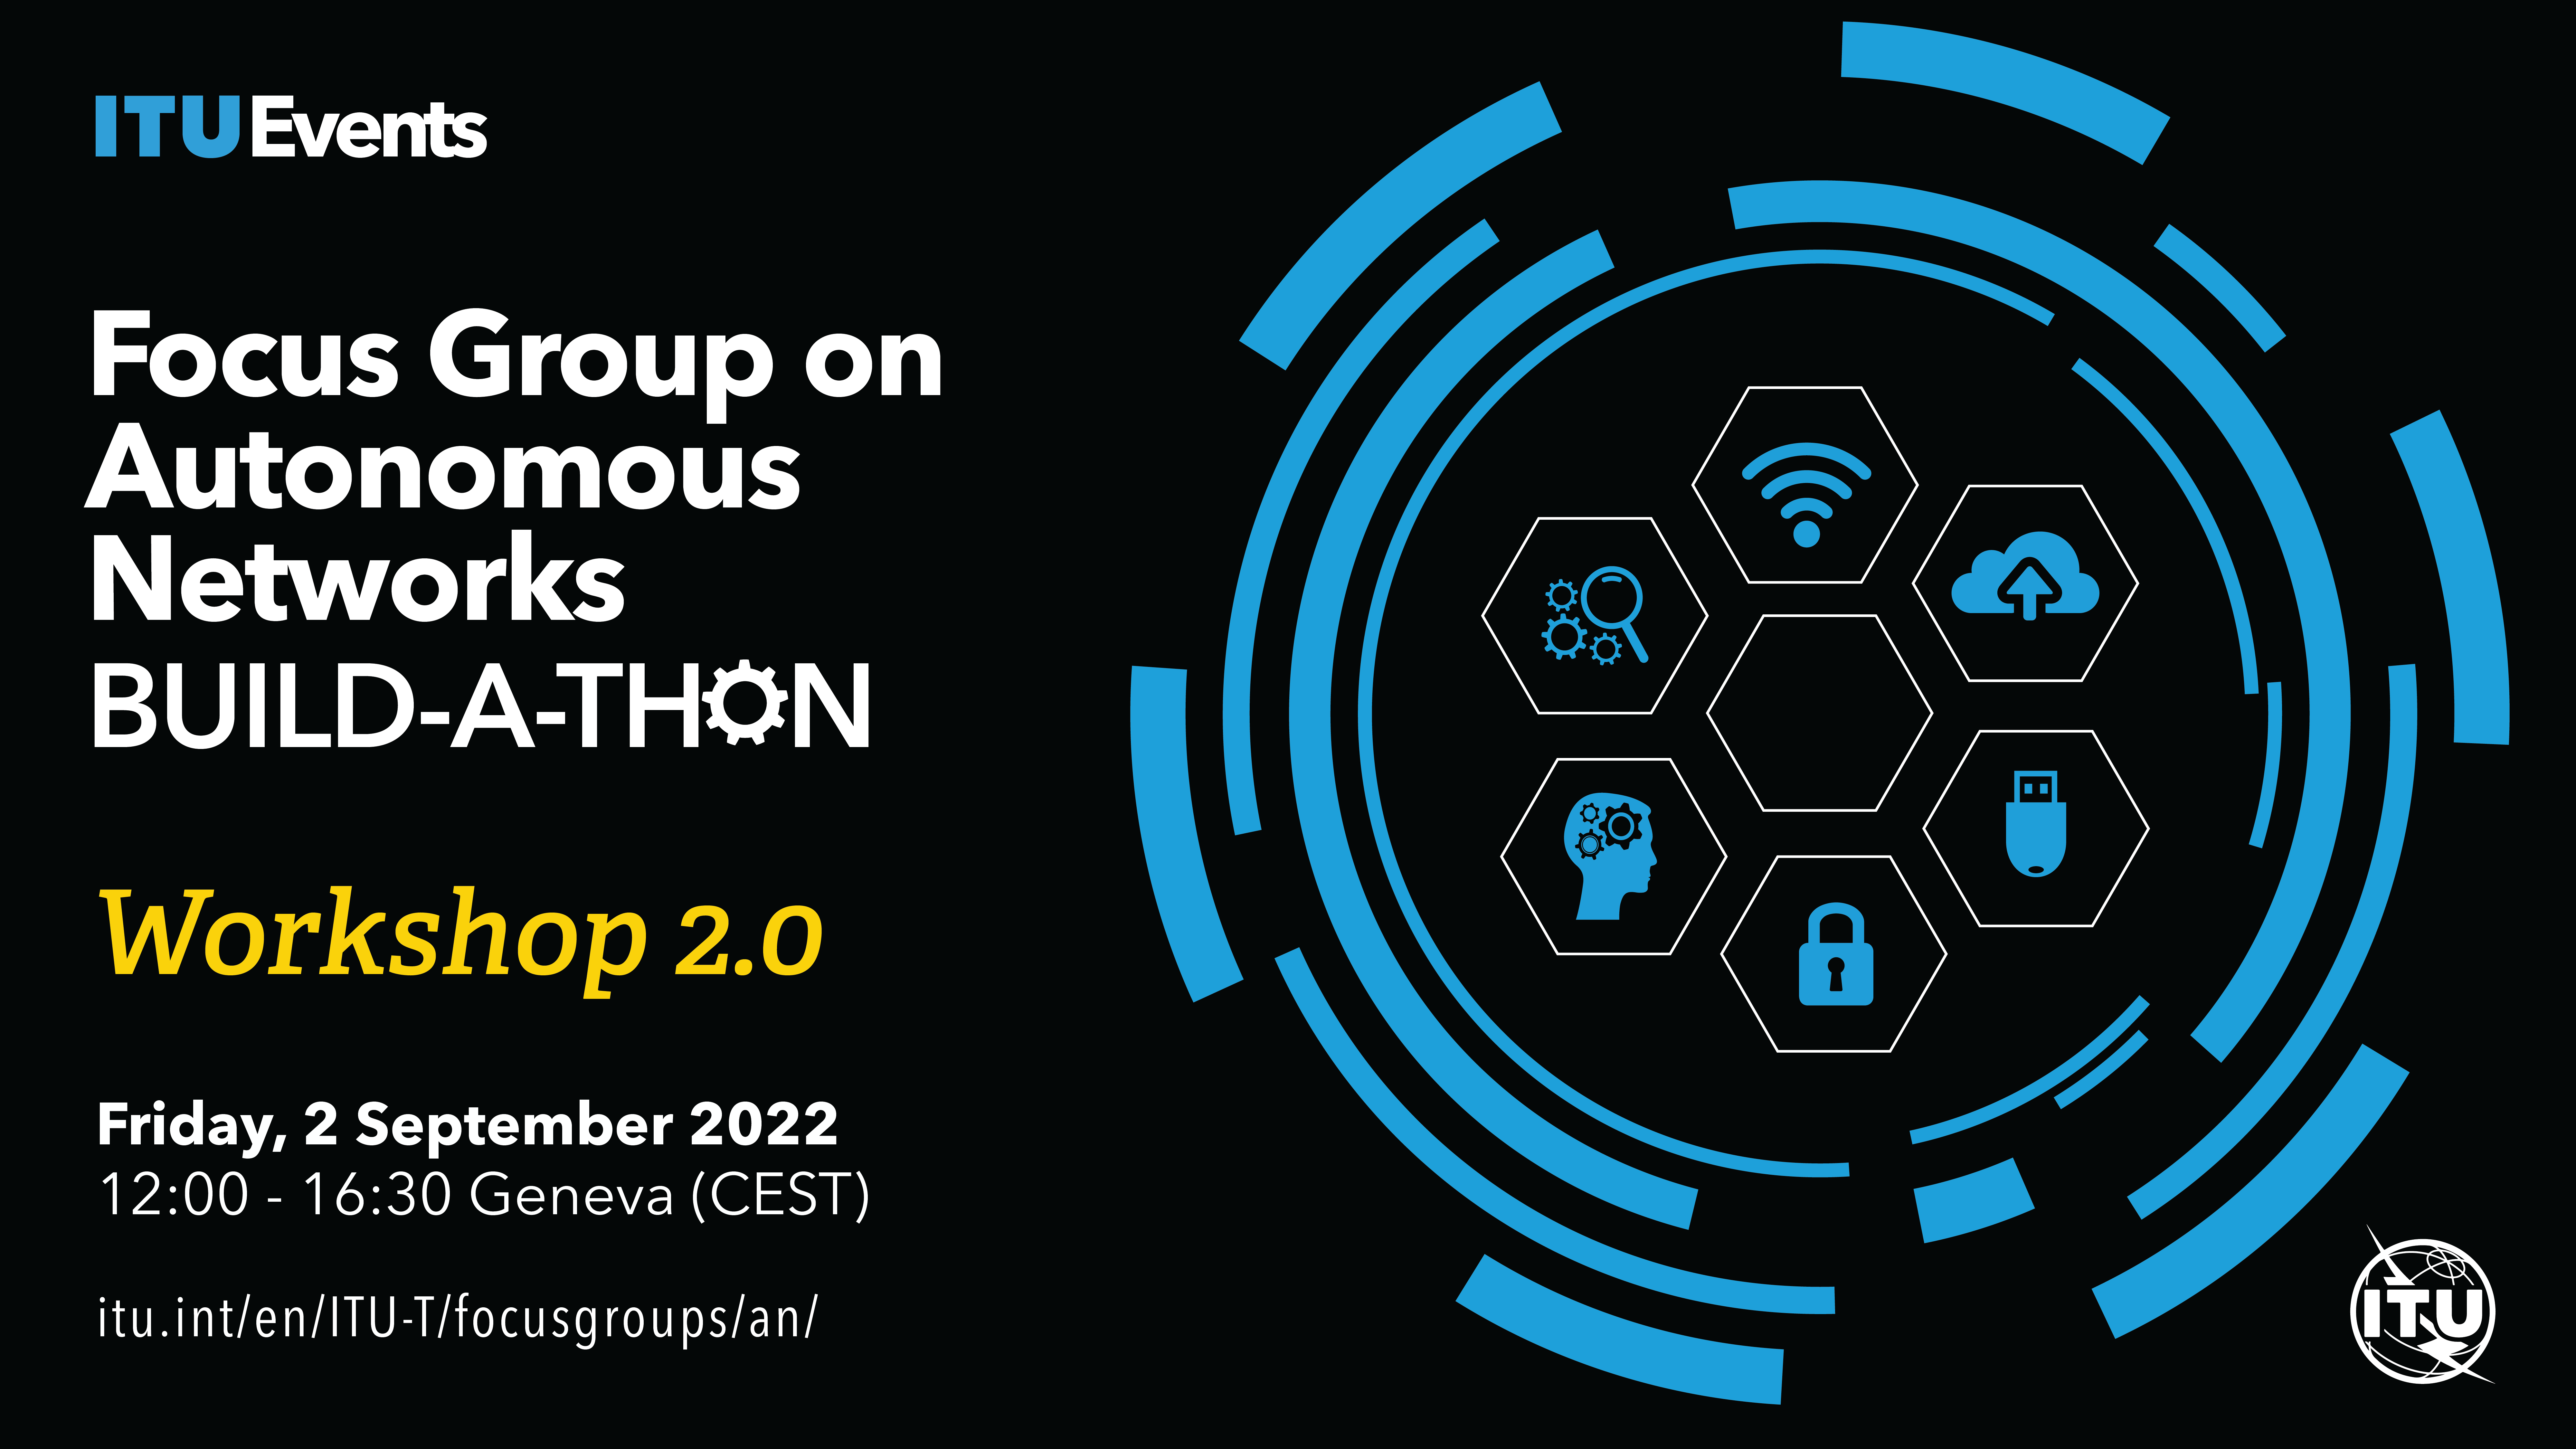

In [2]:
from IPython.display import Image
Image(filename='/tmp/FGAN-Build-a-thon-2022/Banner/1920x1080-FG_AN-buildathon_Sep02-01.png', width=500) 


In [3]:
!rm -rf /tmp/FGAN-Build-a-thon-2022/

## Introduction

Created: 14 Apr 2022.   
Author: Vishnu Ram OV.   
vishnu.n@ieee.org.   
Licence: available for all purposes under the sun  
but with acknowledgement and citation to "ITU FG AN Build-a-thon 2022"


## References 
[1] Neo4j Docs, "Creating an instance", https://neo4j.com/docs/aura/auradb/getting-started/create-database/   
[2] ITU-T Focus Group Autonomous Networks, "Use cases for Autonomous Networks", https://extranet.itu.int/sites/itu-t/focusgroups/an/output/FGAN-O-013-R1.docx  
[3] Build-a-thon github, https://github.com/vrra/FGAN-Build-a-thon-2022

## Prerequisite: 
create a free account at https://console.neo4j.io  
Follow steps at https://extranet.itu.int/sites/itu-t/focusgroups/an/input/FGAN-I-253.pdf  


## General cautions
Property names have strict conventions and rules in neo4j (apparently)

### For Colab users:

If you are using colab, add your credentials here and uncomment these  
and skip to step-1 below.

In [4]:
#uri = "your uri from console.neo4j.io"  
#user = "your username from console.neo4j.io"  
#password = "your passwd from console.neo4j.io"  

### For non-colab users:
Create a local file .env with   
neo4j_uri="your uri from console.neo4j.io"  
neo4j_user="your username from console.neo4j.io"  
neo4j_password="your passwd from console.neo4j.io"  

### Read the neo4j URI, username, passwd


In [1]:
import os
%pip install python-dotenv
from dotenv import load_dotenv
load_dotenv()

Note: you may need to restart the kernel to use updated packages.


True

In [2]:

#Vishnu: 1 Jun 2022: use the details from https://console.neo4j.io
#especially use your own DB instance and corresponding passwd.
#if you dont have a .env file, replace here with your credentials.

uri = os.getenv('neo4j_uri')
user = os.getenv('neo4j_user')
password = os.getenv('neo4j_password')

## step-1: install neo4j

In [3]:
%pip install neo4j

Note: you may need to restart the kernel to use updated packages.


## step-2: imports and init

In [4]:
from neo4j import GraphDatabase
import logging
from neo4j.exceptions import ServiceUnavailable

## step-3: define helper class

In [5]:


class App:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        # Don't forget to close the driver connection when you are finished with it
        self.driver.close()

    #Vishnu: 1 Aug 2022: uses labels instead of properties
    #Vishnu: 1 Aug 2022: Invariant: only 1 actor with 1 name.
    #        (Note that rel still uses properties and not labels)
    def create_node_with_usecase_label(self, actor_name, usecase_id):
        with self.driver.session() as session:
            node_already_exists = session.read_transaction(
                self._find_and_return_existing_node_label, actor_name)
            if not node_already_exists:  
                #node itself doesnt exist (not to mention the use case label), Lets add.
                result = session.write_transaction(
                    self._create_and_return_node_label, actor_name, usecase_id)
                for row in result:
                    print("Created node: {n1}".format(n1=row['n1name']))
            else:
                for row in node_already_exists:
                    print("Node already exists: {name} in {usecase}".format(name=row['n1name'], 
                                                                 usecase=row['n1usecase']))
                    if not (usecase_id in row['n1usecase']):
                      print("adding label "
                                +usecase_id+ 
                                " in addition to {usecase}".format(usecase=row['n1usecase']))
                      result = session.write_transaction(
                                self._add_usecase_and_return_existing_node_label, actor_name, usecase_id)
                    else:
                      print("ignoring ...")
                    #row has only 1 entry due to invariant. So break here. and exit f()
                    break
    
    #Vishnu: 1 Aug 2022: created this f() to query nodes based on a name
    #                    and return with usecase labels
    @staticmethod
    def _find_and_return_existing_node_label(tx, actor_name):
        query = (
            "MATCH (n1) "
            "WHERE (n1.name ='" + actor_name + "') "
            "RETURN n1.name as n1name, labels(n1) as n1usecase"
        )
        result = tx.run(query)
        try:
            return [{"n1name": row["n1name"],"n1usecase": row["n1usecase"]} 
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 1 Aug 2022: created this f() to create nodes with usecase label
    @staticmethod
    def _create_and_return_node_label(tx, actor_name, usecase_id):
            query = (
            "CREATE (n1 :" + usecase_id + " { name: '" + actor_name + "'}) "
            "RETURN n1"
            )
            result = tx.run(query, actor_name=actor_name)
            try:
                return [{"n1name": row["n1"]["name"]}
                        for row in result]
            # Capture any errors along with the query and data for traceability
            except ServiceUnavailable as exception:
                logging.error("{query} raised an error: \n {exception}".format(
                    query=query, exception=exception))
                raise

    #Vishnu: 1 Aug 2022: created this f() to add use case labels to existing nodes
    #                    Note that the existing labels are left there.
    @staticmethod
    def _add_usecase_and_return_existing_node_label(tx, actor_name, usecase_id):
        query = (
            "MATCH "
            "(n1) "
            "WHERE n1.name = '" + actor_name +"' "
            "set n1 :" + usecase_id +" "
            "return n1"
        )
        result = tx.run(query, actor_name=actor_name)
        try:
            return [{"n1": row["n1"]["name"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 1 Aug 2022: created this f() to return all use case actors based on labels
    #                    as against properties
    @staticmethod
    def _find_and_return_all_usecase_actors_label(tx, usecase_id):
        query = (
            "MATCH (n) "
            "WHERE '" +usecase_id+ "' in labels(n) "
            "RETURN n.name AS name"
        )
        result = tx.run(query)
        return [row["name"] for row in result]

    #Vishnu: 1 Aug 2022: created this f() to list all nodes with usecase label
    #                    instead of properties
    def find_all_usecase_actors_label(self, usecase_id):
        with self.driver.session() as session:
            result = session.read_transaction(self._find_and_return_all_usecase_actors_label, usecase_id)
            i=0
            for row in result:
                i=i+1
                print("Found actor-"+ str(i) +": {row}".format(row=row))

    #Vishnu: 1 Aug 2022: Created to use label for use case.
    #CAUTION: Assumes that actors already exists with label as use case.
    #So, this has to be called only in conjunction with create_node_with_usecase
    #otherwise you may end up with actors not having use case prop
    #but rels will have use case prop. not a good idea.
    def create_rel_with_usecase_label(self, actor1_name, rel_name, actor2_name, usecase_id):
        with self.driver.session() as session:
            this_rel_already_exists = session.read_transaction(
                self._find_and_return_this_existing_rels, actor1_name, rel_name, actor2_name, usecase_id)
            if (this_rel_already_exists):
                print(rel_name + " already exists with "+ usecase_id + " between "+ actor1_name + " and "+ actor2_name)
                return
            else:
                #we are pretty sure something didnt match
                #this relation does not exist currently between the nodes under the use case, 
                #add it.
                result3 = session.write_transaction(
                    self._create_and_return_rel_label, actor1_name, rel_name, actor2_name, usecase_id)
                #if (not retult3)
                for row in result3:
                    print("Created relation: {actor1} - {rel} - {actor2} in {usecase}".
                            format(actor1=row['n1name'], 
                            rel=row['r1name'],
                            actor2=row['n2name'],
                            usecase=row['r1usecase']))

    #Vishnu: 1 Aug 2022 
    #assumption: nodes already exist
    #modified from _create_and_return_rel to use labels for n.usecase
    @staticmethod
    def _create_and_return_rel_label(tx, actor1_name, rel_name, actor2_name, usecaseid):
            query = (
            "MATCH "
            "(n1), "
            "(n2) "
            "WHERE n1.name = '" + actor1_name + "' AND n2.name = '"+actor2_name+"' "
            " AND '"+ usecaseid+"' in labels(n1) "
            " AND '"+ usecaseid+"' in labels(n2) "
            "CREATE (n1)-[r1:Relation " + "{name: '"+rel_name+"', usecase: '"+usecaseid+"'} ]->(n2) "
            "RETURN n1, r1, n2"
            )
            result = tx.run(query)
            try:
                return [{"n1name": row["n1"]["name"], 
                        "r1name": row["r1"]["name"],
                        "n2name": row["n2"]["name"],
                        "r1usecase": row["r1"]["usecase"]}
                        for row in result]
            # Capture any errors along with the query and data for traceability
            except ServiceUnavailable as exception:
                logging.error("{query} raised an error: \n {exception}".format(
                    query=query, exception=exception))
                raise

    #Vishnu: 1 Aug 2022: This approach uses properties instead of labels for n.usecases.
    #Vishnu: 1 Aug 2022: Invariant: only 1 actor with 1 name.
    #Vishnu: 22 Jun 2022: refactored, uses properties instead of labels
    #Vishnu: 1 Jun 2022: created this f() to create nodes with usecase label
    #Vishnu: 2 Jun 2022: added- check if it already exists.
    #Vishnu: 2 Jun 2022: added- check the usecase duplication, adds a usecase if it doesnt exist.
    #otherwise ignores the command.
    def create_node_with_usecase(self, actor_name, usecase_id):
        with self.driver.session() as session:
            node_already_exists = session.read_transaction(
                self._find_and_return_existing_node, actor_name)
            if not node_already_exists:  
                result = session.write_transaction(
                    self._create_and_return_node, actor_name, usecase_id)
                for row in result:
                    print("Created node: {n1}".format(n1=row['n1name']))
            else:
                for row in node_already_exists:
                    print("Node already exists: {name} in {usecase}".format(name=row['n1name'], 
                                                                 usecase=row['n1usecase']))
                    s=row['n1usecase'].split(',')
                    if not (usecase_id in s):
                      print("adding prop "+usecase_id+ " in addition to "+row['n1usecase'])
                      result = session.write_transaction(
                                self._add_usecase_and_return_existing_node, actor_name, usecase_id)
                    else:
                      print("ignoring ...")
                    #row has only 1 entry due to invariant. So break here. and exit f()
                    break

    #Vishnu: 1 Aug 2022: This approach uses properties instead of labels for usecases.
    #Vishnu: 2 Jun 2022: created this f() to query nodes and return with usecase prop
    @staticmethod
    def _find_and_return_existing_node(tx, actor_name):
        query = (
            "MATCH (n1) "
            "WHERE (n1.name ='" + actor_name + "') "
            "RETURN n1.name as n1name, n1.usecase as n1usecase"
        )
        result = tx.run(query)
        try:
            return [{"n1name": row["n1name"],"n1usecase": row["n1usecase"]} 
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 1 Aug 2022: This approach uses properties instead of labels for usecases.
    @staticmethod
    def _create_and_return_node(tx, actor_name, usecase_id):
            query = (
            "CREATE (n1 "+"{ name: '"+actor_name+"', usecase: '"+usecase_id+"'}) "
            "RETURN n1"
            )
            result = tx.run(query, actor_name=actor_name)
            try:
                return [{"n1name": row["n1"]["name"]}
                        for row in result]
            # Capture any errors along with the query and data for traceability
            except ServiceUnavailable as exception:
                logging.error("{query} raised an error: \n {exception}".format(
                    query=query, exception=exception))
                raise

    #Vishnu: 1 Aug 2022: This approach uses properties instead of labels for usecases.
    #Vishnu: 1 Jun 2022: created this f() to add use case prop to existing nodes 
    #CAUTION: does not check for duplication, use create_node_with_prop instead.
    def add_usecase_existing_node(self, actor_name, usecase_id):
        with self.driver.session() as session:
            # Write transactions allow the driver to handle retries and transient errors
            result = session.write_transaction(
                self._add_usecase_and_return_existing_node, actor_name, usecase_id)
            
            # we expect only 1 node. Do we need the for loop below?
            for row in result:
                print("added usecase to node: {n1}".format(n1=row['n1']))

    #Vishnu: 1 Aug 2022: This approach uses properties instead of labels for usecases.
    @staticmethod
    def _add_usecase_and_return_existing_node(tx, actor_name, usecase_id):
        # To learn more about the Cypher syntax, see https://neo4j.com/docs/cypher-manual/current/
        # The Reference Card is also a good resource for keywords https://neo4j.com/docs/cypher-refcard/current/
        query = (
            "MATCH "
            "(n1) "
            "WHERE n1.name = '" + actor_name +"' "
            "set n1.usecase = n1.usecase + '" + "," + "'"+ "+ '"+usecase_id +"' "
            "return n1"
        )
        result = tx.run(query, actor_name=actor_name)
        try:
            return [{"n1": row["n1"]["name"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 1 Aug 2022: This approach uses properties instead of labels for usecases.
    #CAUTION: Assumes that actors already exists with property as n.use case.
    #So, this has to be called only in conjunction with create_node_with_usecase
    #otherwise you may end up with actors not having use case prop
    #but rels will have use case prop. not a good idea.
    def create_rel_with_usecase(self, actor1_name, rel_name, actor2_name, usecase_id):
        with self.driver.session() as session:
            this_rel_already_exists = session.read_transaction(
                self._find_and_return_this_existing_rels, actor1_name, rel_name, actor2_name, usecase_id)
            if (this_rel_already_exists):
                print(rel_name + " already exists with "+ usecase_id + " between "+ actor1_name + " and "+ actor2_name)
                return
            else:
                #we are pretty sure something didnt match
                #this relation does not exist currently between the nodes under the use case, 
                #add it.
                result3 = session.write_transaction(
                    self._create_and_return_rel, actor1_name, rel_name, actor2_name, usecase_id)
                #if (not retult3)
                for row in result3:
                    print("Created relation: {actor1} - {rel} - {actor2} in {usecase}".
                            format(actor1=row['n1name'], 
                            rel=row['r1name'],
                            actor2=row['n2name'],
                            usecase=row['r1usecase']))
    
    #Vishnu: 1 Aug 2022: at this moment this f() uses labels instead of properties for n.usecases.
    #                    Note that rels still uses properties.
    #        1 Aug 2022: TBD: create a property-version (as against label) of the same thing.
    #Vishnu: 21 Jun 2022: created this f() to create relationships with usecase label
    #if this works, this is the only function that needed to be called.
    def create_actors_relationship_with_usecase(self, actor1_name, rel_name, actor2_name, usecase_id):
            #process actor1
            self.create_node_with_usecase_label(actor1_name, usecase_id)
            #process actor2
            self.create_node_with_usecase_label(actor2_name, usecase_id)
            #process relation
            self.create_rel_with_usecase_label(actor1_name, rel_name, actor2_name, usecase_id)

    #Vishnu: 23 June 2022: created
    #looks for a rel under a use case between 2 given nodes.
    #normally, we expect only 0 or 1 unique entry.
    @staticmethod                
    def _find_and_return_this_existing_rels(tx, actor1_name, rel_name, actor2_name, usecase_id):
        query = (
            "MATCH (n1)-[r1]-(n2) "
            "WHERE (n1.name ='" + actor1_name + "') "
            "and   (n2.name ='" + actor2_name + "') "
            "and   (r1.usecase CONTAINS '"+ usecase_id+ "') "
            "and   (r1.name ='" + rel_name + "') "
            "RETURN n1.name as n1name, r1.name as r1name, n2.name as n2name, r1.usecase as r1usecase"
        )
        result = tx.run(query)
        return [row["r1name"] for row in result]
        
    
    #Vishnu: 21 June 2022: created this supporting f()
    #return for all relationship between given two nodes.
    @staticmethod                
    def _find_and_return_all_existing_rels_for_uc(tx, actor1_name, actor2_name, usecase_id):
        query = (
            "MATCH (n1)-[r1]-(n2) "
            "WHERE (n1.name ='" + actor1_name + "') "
            "and   (n2.name ='" + actor2_name + "') "
            "and   (r1.usecase CONTAINS '"+ usecase_id+ "') "
            "RETURN n1.name as n1name, r1.name as r1name, n2.name as n2name, r1.usecase as r1usecase"
        )
        result = tx.run(query)
        try:
            return [{
                        "n1name": row["n1name"],
                        "n2name": row["n2name"],
                        "r1name": row["r1name"],
                        "r1usecase": row["r1usecase"],
                    } 
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 21 June 2022: created this supporting f()
    #adds a name for an existing relationship between given two nodes.
    @staticmethod                
    def _add_usecase_and_return_existing_rel(tx, actor1_name, rel_name, actor2_name, usecase_id):
        query = (
            "MATCH (n1)-[r1]-(n2) "
            "WHERE (n1.name ='" + actor1_name + "') "
            "and   (n2.name ='" + actor2_name + "')"
            "set    r1.usecase = r1.usecase + '" + "," + "'"+ "+ '"+usecase_id +"' "
        )
        result = tx.run(query)

    
    #Vishnu: 30 june 2022: created
    #CAUTION: if the property already exists, 
    #this overwrites the current value.
    @staticmethod
    def _write_property_and_return_existing_node(tx, actor_name, propertyName, propertyVal):
        query = (
            "MATCH "
            "(n1) "
            "WHERE n1.name = '" + actor_name +"' "
            "set n1."+propertyName+" = '"+propertyVal +"' "
            "return n1"
        )
        result = tx.run(query, actor_name=actor_name)
        try:
            return [{"n1": row["n1"]["name"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 30 june 2022: created
    #CAUTION: if the property already exists, 
    #this overwrites the current value.
    @staticmethod
    def _write_property_and_return_existing_rel(tx, actor1_name, rel_name, actor2_name, 
                                                propertyName, propertyVal):
        query = (
            "MATCH (n1)-[r1]-(n2) "
            "WHERE (n1.name ='" + actor1_name + "') "
            "and   (n2.name ='" + actor2_name + "') "
            "and   (r1.name ='" + rel_name + "') "
            "set   r1."+propertyName+" = '"+propertyVal +"' "
            "return r1"
        )
        result = tx.run(query)
        try:
            return [{"r1": row["r1"]["name"]}
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    #Vishnu: 22 June 2022: created
    #assumption: nodes already exist
    @staticmethod
    def _create_and_return_rel(tx, actor1_name, rel_name, actor2_name, usecaseid):
            query = (
            "MATCH "
            "(n1), "
            "(n2) "
            "WHERE n1.name = '" + actor1_name + "' AND n2.name = '"+actor2_name+"' "
            " AND n1.usecase CONTAINS '"+ usecaseid+"' "
            " AND n2.usecase CONTAINS '"+ usecaseid+"' "
            "CREATE (n1)-[r1:Relation " + "{name: '"+rel_name+"', usecase: '"+usecaseid+"'} ]->(n2) "
            "RETURN n1, r1, n2"
            )
            result = tx.run(query)
            try:
                return [{"n1name": row["n1"]["name"], 
                        "r1name": row["r1"]["name"],
                        "n2name": row["n2"]["name"],
                        "r1usecase": row["r1"]["usecase"]}
                        for row in result]
            # Capture any errors along with the query and data for traceability
            except ServiceUnavailable as exception:
                logging.error("{query} raised an error: \n {exception}".format(
                    query=query, exception=exception))
                raise

    #Vishnu: 1 Jun 2022: created this f() to list all nodes with usecase label
    def find_all_usecase_actors(self, usecase_id):
        with self.driver.session() as session:
            result = session.read_transaction(self._find_and_return_all_usecase_actors, usecase_id)
            i=0
            for row in result:
                i=i+1
                print("Found actor-"+ str(i) +": {row}".format(row=row))

    @staticmethod
    def _find_and_return_all_usecase_actors(tx, usecase_id):
        query = (
            "MATCH (n) "
            "WHERE (n.usecase = '"+usecase_id+"') "
            "RETURN n.name AS name"
        )
        result = tx.run(query)
        return [row["name"] for row in result]

    #Vishnu: 21 Jun 2022: created this f() to cleanup the DB
    #CAUTION: will delete everything
    def cleanup_db(self):
        with self.driver.session() as session:
            result = session.read_transaction(
                self._count_nodes_in_db)
            for row in result:
                print("Found {row} actors, deleting! ".format(row=row['count']))
            result = session.write_transaction(
                self._cleanup_db)

    #Vishnu: 22 June 2022: created this f() 
    #(over)writes a prop to a node
    def writePropToNode(self, actor_name, propertyName, propertyVal):
        with self.driver.session() as session:
            result = session.write_transaction(
                self._write_property_and_return_existing_node, 
                    actor_name, 
                    propertyName, 
                    propertyVal)
        
            # we expect only 1 node. Do we need the for loop below?
            for row in result:
                print("added prop "+
                        propertyName+
                        " = "+
                        propertyVal+
                        " to node: {n1}".format(n1=row['n1']))

    #Vishnu: 22 June 2022: created this f() 
    #(over)writes a prop to a rel
    def writePropToRel(self, a1, rel_name, a2, propertyName, propertyVal):
        with self.driver.session() as session:
            result = session.write_transaction(
                self._write_property_and_return_existing_rel, 
                    a1, rel_name, a2,
                    propertyName, 
                    propertyVal)
        
            # we expect only 1 node. Do we need the for loop below?
            for row in result:
                print("added prop "+
                        propertyName+
                        " = "+
                        propertyVal+
                        " to rel: {r1}".format(r1=row['r1']))

    @staticmethod
    def _cleanup_db(tx):
        query = (
            "MATCH (n) "
            "detach delete n"
        )
        result = tx.run(query)
        try:
            return 
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

    @staticmethod
    def _count_nodes_in_db(tx):
        query = (
            "MATCH (n) "
            "return count(n) as count"
        )
        result = tx.run(query)
        try:
            return [{"count": row["count"]} 
                    for row in result]
        # Capture any errors along with the query and data for traceability
        except ServiceUnavailable as exception:
            logging.error("{query} raised an error: \n {exception}".format(
                query=query, exception=exception))
            raise

## step-4: instantiate the helper class to DB. 
CAUTION: this uses the username/passwd assigned already in step-2 above.

In [6]:
app = App(uri, user, password)

## step-5 clean up DB
#Caution: lose data


In [7]:
app.cleanup_db()

Found 43 actors, deleting! 


## Examples

In [11]:
app.create_actors_relationship_with_usecase("Experimentation Controller", 
                                            "myrel", 
                                            "Sandbox",
                                            "usecase_001")

Created node: Experimentation Controller
Created node: Sandbox
Created relation: Experimentation Controller - myrel - Sandbox in usecase_001


### Example-1: Create individual nodes with usecase
(and add a node property)
(and add a rel property)

In [75]:
app.create_node_with_usecase("Experimentation Controller", "usecase_001")
app.create_node_with_usecase("Sandbox", "usecase_001")


Node already exists: Experimentation Controller in usecase_001
ignoring ...
Node already exists: Sandbox in usecase_001
ignoring ...


In [12]:
app.writePropToNode("Sandbox", "capability", "import knowledge")


added prop capability = import knowledge to node: Sandbox


In [13]:
app.writePropToNode("Sandbox", "requirement", "integrate controllers")


added prop requirement = integrate controllers to node: Sandbox


### Example-1a: try to create duplicate node under different use case

In [14]:
app.create_node_with_usecase("Sandbox", "usecase_003")
app.create_node_with_usecase("Sandbox", "usecase_004")
app.create_node_with_usecase("Sandbox", "usecase_005")
app.create_node_with_usecase("Sandbox", "usecase_006")


Node already exists: Sandbox in usecase_001
adding prop usecase_003 in addition to usecase_001
Node already exists: Sandbox in usecase_001,usecase_003
adding prop usecase_004 in addition to usecase_001,usecase_003
Node already exists: Sandbox in usecase_001,usecase_003,usecase_004
adding prop usecase_005 in addition to usecase_001,usecase_003,usecase_004
Node already exists: Sandbox in usecase_001,usecase_003,usecase_004,usecase_005
adding prop usecase_006 in addition to usecase_001,usecase_003,usecase_004,usecase_005


### Example-1b: use create_node_with_usecase_label (instead of properties)

In [28]:
app.create_node_with_usecase_label("Sandbox", "usecase_003")
app.create_node_with_usecase_label("Sandbox", "usecase_003")
app.create_node_with_usecase_label("Sandbox", "usecase_004")
app.create_node_with_usecase_label("Sandbox", "usecase_004")
app.create_node_with_usecase_label("Sandbox", "usecase_005")



Node already exists: Sandbox in ['usecase_003', 'usecase_004']
ignoring ...
Node already exists: Sandbox in ['usecase_003', 'usecase_004']
ignoring ...
Node already exists: Sandbox in ['usecase_003', 'usecase_004']
ignoring ...
Node already exists: Sandbox in ['usecase_003', 'usecase_004']
ignoring ...
Node already exists: Sandbox in ['usecase_003', 'usecase_004']
adding label usecase_005 in addition to ['usecase_003', 'usecase_004']


### Example-2: Create relation between 2 existing nodes

In [15]:
app.create_rel_with_usecase("Experimentation Controller", "my_best_buddy", "Sandbox", "usecase_001")
app.create_rel_with_usecase("Experimentation Controller", "my_best_buddy", "Sandbox", "usecase_002")
app.create_rel_with_usecase("Experimentation Controller", "my_best_buddy", "Sandbox", "usecase_003")


Created relation: Experimentation Controller - my_best_buddy - Sandbox in usecase_001


In [79]:
app.writePropToRel("Experimentation Controller", "my_best_buddy", "Sandbox", 
                    "my_rel_prop_name", 
                    "my-rel-prop-val")

added prop my_rel_prop_name = my-rel-prop-val to rel: my_best_buddy


## Cleanup DB 
CAUTION: Remember to clean up the DB before executing the next steps. (so that all examples above are not leftover in the use case data below).

In [25]:
app.cleanup_db()

Failed to read from defunct connection ResolvedIPv4Address(('34.126.114.186', 7687)) (IPv4Address(('34.126.114.186', 7687)))
Unable to retrieve routing information
Transaction failed and will be retried in 0.8310364280249959s (Unable to retrieve routing information)


Found 48 actors, deleting! 


## USECASES

### FG-AN-USECASE-001

In [26]:

app.create_actors_relationship_with_usecase("Knowledge Base", "import", "Knowledge Base", "usecase_001")
app.create_actors_relationship_with_usecase("Knowledge Base", "export", "Knowledge Base", "usecase_001")

app.create_actors_relationship_with_usecase("Knowledge Base Manager", "optimizes", "Knowledge Base", "usecase_001")
app.create_actors_relationship_with_usecase("Knowledge Base Manager", "export", "Knowledge Base", "usecase_001")

app.create_actors_relationship_with_usecase("AN Orchestrator", "refer", "Knowledge Base", "usecase_001")
app.create_actors_relationship_with_usecase("AN Orchestrator", "input", "Use case description", "usecase_001")
app.create_actors_relationship_with_usecase("AN Orchestrator", "output", "TOSCA format", "usecase_001")

app.create_actors_relationship_with_usecase("Auto controller generator", "refer", "Knowledge Base", "usecase_001")
app.create_actors_relationship_with_usecase("Auto controller generator", "output", "TOSCA format", "usecase_001")

app.create_actors_relationship_with_usecase("controller repository", "stores", "controllers", "usecase_001")
app.create_actors_relationship_with_usecase("ML model", "recommends", "controllers", "usecase_001")

app.create_actors_relationship_with_usecase("Human operator", "input", "reports", "usecase_001")
app.create_actors_relationship_with_usecase("Human operator", "monitors", "reports", "usecase_001")

Created node: Knowledge Base
Node already exists: Knowledge Base in ['usecase_001']
ignoring ...
Created relation: Knowledge Base - import - Knowledge Base in usecase_001
Node already exists: Knowledge Base in ['usecase_001']
ignoring ...
Node already exists: Knowledge Base in ['usecase_001']
ignoring ...
Created relation: Knowledge Base - export - Knowledge Base in usecase_001
Created node: Knowledge Base Manager
Node already exists: Knowledge Base in ['usecase_001']
ignoring ...
Created relation: Knowledge Base Manager - optimizes - Knowledge Base in usecase_001
Node already exists: Knowledge Base Manager in ['usecase_001']
ignoring ...
Node already exists: Knowledge Base in ['usecase_001']
ignoring ...
Created relation: Knowledge Base Manager - export - Knowledge Base in usecase_001
Created node: AN Orchestrator
Node already exists: Knowledge Base in ['usecase_001']
ignoring ...
Created relation: AN Orchestrator - refer - Knowledge Base in usecase_001
Node already exists: AN Orchest

In [27]:
app.find_all_usecase_actors_label("usecase_001")

Found actor-1: Knowledge Base
Found actor-2: Knowledge Base Manager
Found actor-3: AN Orchestrator
Found actor-4: Use case description
Found actor-5: TOSCA format
Found actor-6: Auto controller generator
Found actor-7: controller repository
Found actor-8: controllers
Found actor-9: ML model
Found actor-10: Human operator
Found actor-11: reports


### FG-AN-USECASE-002


In [28]:
app.create_actors_relationship_with_usecase("Experimentation controller", "decides", 
                                        "scenarios for experimentation", "usecase_002")
app.create_actors_relationship_with_usecase("AN sandbox", "hosts", 
                                        "simulators", "usecase_002")
app.create_actors_relationship_with_usecase("AN sandbox", "manages", 
                                        "simulators", "usecase_002")
app.create_actors_relationship_with_usecase("AN sandbox", "output", 
                                        "reports", "usecase_002")
app.create_actors_relationship_with_usecase("Experimentation controller", "triggers", 
                                        "experiments", "usecase_002")
app.create_actors_relationship_with_usecase("Experimentation controller", "output", 
                                        "reports", "usecase_002")
app.create_actors_relationship_with_usecase("Experimentation controller", "executes", 
                                        "experiments", "usecase_002")
app.create_actors_relationship_with_usecase("Experimentation controller", "monitors", 
                                        "experiments", "usecase_002")
app.create_actors_relationship_with_usecase("Experimentation controller", "uses", 
                                        "AN sandbox", "usecase_002")
app.create_actors_relationship_with_usecase("Experimentation controller", "updates", 
                                        "Knowledge Base", "usecase_002")
app.create_actors_relationship_with_usecase("experiments", "has", 
                                        "scenarios for experimentation", "usecase_002")

Created node: Experimentation controller
Created node: scenarios for experimentation
Created relation: Experimentation controller - decides - scenarios for experimentation in usecase_002
Created node: AN sandbox
Created node: simulators
Created relation: AN sandbox - hosts - simulators in usecase_002
Node already exists: AN sandbox in ['usecase_002']
ignoring ...
Node already exists: simulators in ['usecase_002']
ignoring ...
Created relation: AN sandbox - manages - simulators in usecase_002
Node already exists: AN sandbox in ['usecase_002']
ignoring ...
Node already exists: reports in ['usecase_001']
adding label usecase_002 in addition to ['usecase_001']
Created relation: AN sandbox - output - reports in usecase_002
Node already exists: Experimentation controller in ['usecase_002']
ignoring ...
Created node: experiments
Created relation: Experimentation controller - triggers - experiments in usecase_002
Node already exists: Experimentation controller in ['usecase_002']
ignoring ...
N

In [29]:
app.find_all_usecase_actors_label("usecase_002")

Found actor-1: Knowledge Base
Found actor-2: reports
Found actor-3: Experimentation controller
Found actor-4: scenarios for experimentation
Found actor-5: AN sandbox
Found actor-6: simulators
Found actor-7: experiments


### FG-AN-USECASE-003


In [30]:
app.create_actors_relationship_with_usecase("AN Orchestrator", "queries", 
                                        "AN Orchestrator", "usecase_003")
app.create_actors_relationship_with_usecase("AN Orchestrator", "queries", 
                                        "Human operator", "usecase_003")
app.create_actors_relationship_with_usecase("AN Orchestrator", "accept", 
                                        "feedback", "usecase_003")
app.create_actors_relationship_with_usecase("AN Orchestrator", "configures", 
                                        "AN components", "usecase_003")
app.create_actors_relationship_with_usecase("AN Orchestrator", "updates", 
                                        "Knowledge Base", "usecase_003")


Node already exists: AN Orchestrator in ['usecase_001']
adding label usecase_003 in addition to ['usecase_001']
Node already exists: AN Orchestrator in ['usecase_001', 'usecase_003']
ignoring ...
Created relation: AN Orchestrator - queries - AN Orchestrator in usecase_003
Node already exists: AN Orchestrator in ['usecase_001', 'usecase_003']
ignoring ...
Node already exists: Human operator in ['usecase_001']
adding label usecase_003 in addition to ['usecase_001']
Created relation: AN Orchestrator - queries - Human operator in usecase_003
Node already exists: AN Orchestrator in ['usecase_001', 'usecase_003']
ignoring ...
Created node: feedback
Created relation: AN Orchestrator - accept - feedback in usecase_003
Node already exists: AN Orchestrator in ['usecase_001', 'usecase_003']
ignoring ...
Created node: AN components
Created relation: AN Orchestrator - configures - AN components in usecase_003
Node already exists: AN Orchestrator in ['usecase_001', 'usecase_003']
ignoring ...
Node a

In [31]:
app.find_all_usecase_actors_label("usecase_003")

Found actor-1: Knowledge Base
Found actor-2: AN Orchestrator
Found actor-3: Human operator
Found actor-4: feedback
Found actor-5: AN components


### FG-AN-USECASE-004

In [32]:
app.create_actors_relationship_with_usecase("Adaptation controller", "discovers", 
                                        "controllers", "usecase_004")
app.create_actors_relationship_with_usecase("Adaptation controller", "deploy", 
                                        "controllers", "usecase_004")
app.create_actors_relationship_with_usecase("Adaptation controller", "configures", 
                                        "controllers", "usecase_004")
app.create_actors_relationship_with_usecase("Adaptation controller", "queries", 
                                        "controller repository", "usecase_004")          
app.create_actors_relationship_with_usecase("Adaptation controller", "updates", 
                                        "Knowledge Base", "usecase_004")  
app.create_actors_relationship_with_usecase("controllers", "is", 
                                        "undeployed controllers", "usecase_004")  
app.create_actors_relationship_with_usecase("controllers", "is", 
                                        "deployed controllers", "usecase_004")                                         

Created node: Adaptation controller
Node already exists: controllers in ['usecase_001']
adding label usecase_004 in addition to ['usecase_001']
Created relation: Adaptation controller - discovers - controllers in usecase_004
Node already exists: Adaptation controller in ['usecase_004']
ignoring ...
Node already exists: controllers in ['usecase_001', 'usecase_004']
ignoring ...
Created relation: Adaptation controller - deploy - controllers in usecase_004
Node already exists: Adaptation controller in ['usecase_004']
ignoring ...
Node already exists: controllers in ['usecase_001', 'usecase_004']
ignoring ...
Created relation: Adaptation controller - configures - controllers in usecase_004
Node already exists: Adaptation controller in ['usecase_004']
ignoring ...
Node already exists: controller repository in ['usecase_001']
adding label usecase_004 in addition to ['usecase_001']
Created relation: Adaptation controller - queries - controller repository in usecase_004
Node already exists: Ad

In [33]:
app.find_all_usecase_actors_label("usecase_004")

Found actor-1: Knowledge Base
Found actor-2: controller repository
Found actor-3: controllers
Found actor-4: Adaptation controller
Found actor-5: undeployed controllers
Found actor-6: deployed controllers


### FG-AN-USECASE-005

In [34]:
app.create_actors_relationship_with_usecase("Service management framework", "is", 
                                        "underlay", "usecase_005")
app.create_actors_relationship_with_usecase("Adaptation controller", "discover", 
                                        "Service management framework", "usecase_005")     
app.create_actors_relationship_with_usecase("Adaptation controller", "influence", 
                                        "Service management framework", "usecase_005")  
app.create_actors_relationship_with_usecase("intent", "is", 
                                        "influence", "usecase_005")  
app.create_actors_relationship_with_usecase("policy", "is", 
                                        "influence", "usecase_005")                                         

Created node: Service management framework
Created node: underlay
Created relation: Service management framework - is - underlay in usecase_005
Node already exists: Adaptation controller in ['usecase_004']
adding label usecase_005 in addition to ['usecase_004']
Node already exists: Service management framework in ['usecase_005']
ignoring ...
Created relation: Adaptation controller - discover - Service management framework in usecase_005
Node already exists: Adaptation controller in ['usecase_004', 'usecase_005']
ignoring ...
Node already exists: Service management framework in ['usecase_005']
ignoring ...
Created relation: Adaptation controller - influence - Service management framework in usecase_005
Created node: intent
Created node: influence
Created relation: intent - is - influence in usecase_005
Created node: policy
Node already exists: influence in ['usecase_005']
ignoring ...
Created relation: policy - is - influence in usecase_005


In [35]:
app.find_all_usecase_actors_label("usecase_005")

Found actor-1: Adaptation controller
Found actor-2: Service management framework
Found actor-3: underlay
Found actor-4: intent
Found actor-5: influence
Found actor-6: policy


### FG-AN-USECASE-006 cat1

In [36]:
app.create_actors_relationship_with_usecase("Evolution controller", "monitors", 
                                        "controllers", "usecase_006_cat1")
app.create_actors_relationship_with_usecase("Evolution controller", "discovers", 
                                        "use cases", "usecase_006_cat1")     
app.create_actors_relationship_with_usecase("Evolution controller", "recommends", 
                                        "controllers", "usecase_006_cat1")  
app.create_actors_relationship_with_usecase("Evolution controller", "refers", 
                                        "Knowledge Base", "usecase_006_cat1")  

Created node: Evolution controller
Node already exists: controllers in ['usecase_001', 'usecase_004']
adding label usecase_006_cat1 in addition to ['usecase_001', 'usecase_004']
Created relation: Evolution controller - monitors - controllers in usecase_006_cat1
Node already exists: Evolution controller in ['usecase_006_cat1']
ignoring ...
Created node: use cases
Created relation: Evolution controller - discovers - use cases in usecase_006_cat1
Node already exists: Evolution controller in ['usecase_006_cat1']
ignoring ...
Node already exists: controllers in ['usecase_001', 'usecase_004', 'usecase_006_cat1']
ignoring ...
Created relation: Evolution controller - recommends - controllers in usecase_006_cat1
Node already exists: Evolution controller in ['usecase_006_cat1']
ignoring ...
Node already exists: Knowledge Base in ['usecase_001', 'usecase_002', 'usecase_003', 'usecase_004']
adding label usecase_006_cat1 in addition to ['usecase_001', 'usecase_002', 'usecase_003', 'usecase_004']
Cr

In [37]:
app.find_all_usecase_actors_label("usecase_006_cat1")

Found actor-1: Knowledge Base
Found actor-2: controllers
Found actor-3: Evolution controller
Found actor-4: use cases


### FG-AN-USECASE-006 cat2

In [38]:
app.create_actors_relationship_with_usecase("Data collector", "consumes", 
                                        "data", "usecase_006_cat2")
app.create_actors_relationship_with_usecase("Management domain", "produces", 
                                        "data", "usecase_006_cat2")     
app.create_actors_relationship_with_usecase("Management domain", "has", 
                                        "RAN cell", "usecase_006_cat2")  
app.create_actors_relationship_with_usecase("Data collector", "produces", 
                                        "data", "usecase_006_cat2") 

app.create_actors_relationship_with_usecase("data", "has", 
                                        "real time", "usecase_006_cat2")     
app.create_actors_relationship_with_usecase("data", "has", 
                                        "data quality", "usecase_006_cat2")  
app.create_actors_relationship_with_usecase("data", "has", 
                                        "KPI", "usecase_006_cat2") 

app.create_actors_relationship_with_usecase("Data monitor", "consumes", 
                                        "data", "usecase_006_cat2")     
app.create_actors_relationship_with_usecase("Data monitor", "has", 
                                        "data monitoring", "usecase_006_cat2")  
app.create_actors_relationship_with_usecase("Data monitor", "produces", 
                                        "reports", "usecase_006_cat2") 
app.create_actors_relationship_with_usecase("reports", "has", 
                                        "visualizations", "usecase_006_cat2")                                         
app.create_actors_relationship_with_usecase("Data analytics", "consumes", 
                                        "data", "usecase_006_cat2")    
app.create_actors_relationship_with_usecase("Data analytics", "produces", 
                                        "inference", "usecase_006_cat2")                                           
app.create_actors_relationship_with_usecase("Data analytics", "has", 
                                        "ML model", "usecase_006_cat2") 
app.create_actors_relationship_with_usecase("inference", "has", 
                                        "periodicity", "usecase_006_cat2")      
app.create_actors_relationship_with_usecase("ML model", "has", 
                                        "model training", "usecase_006_cat2")

Created node: Data collector
Created node: data
Created relation: Data collector - consumes - data in usecase_006_cat2
Created node: Management domain
Node already exists: data in ['usecase_006_cat2']
ignoring ...
Created relation: Management domain - produces - data in usecase_006_cat2
Node already exists: Management domain in ['usecase_006_cat2']
ignoring ...
Created node: RAN cell
Created relation: Management domain - has - RAN cell in usecase_006_cat2
Node already exists: Data collector in ['usecase_006_cat2']
ignoring ...
Node already exists: data in ['usecase_006_cat2']
ignoring ...
Created relation: Data collector - produces - data in usecase_006_cat2
Node already exists: data in ['usecase_006_cat2']
ignoring ...
Created node: real time
Created relation: data - has - real time in usecase_006_cat2
Node already exists: data in ['usecase_006_cat2']
ignoring ...
Created node: data quality
Created relation: data - has - data quality in usecase_006_cat2
Node already exists: data in ['

In [39]:
app.find_all_usecase_actors_label("usecase_006_cat2")

Found actor-1: ML model
Found actor-2: reports
Found actor-3: Data collector
Found actor-4: data
Found actor-5: Management domain
Found actor-6: RAN cell
Found actor-7: real time
Found actor-8: data quality
Found actor-9: KPI
Found actor-10: Data monitor
Found actor-11: data monitoring
Found actor-12: visualizations
Found actor-13: Data analytics
Found actor-14: inference
Found actor-15: periodicity
Found actor-16: model training


### FG-AN-USECASE-007 cat1

In [40]:
app.create_actors_relationship_with_usecase("Adaptation controller", "discovers deployed", 
                                        "CL automation framework", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("CL automation framework", "deploys", 
                                        "controllers", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("controllers", "has", 
                                        "automatic data acquisition", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("controllers", "has", 
                                        "ML model", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("controllers", "has", 
                                        "policy", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("controllers", "has", 
                                        "action implementation", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("policy", "need", 
                                        "optimization", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("Adaptation controller", "configures", 
                                        "controllers", "usecase_007_cat1")
app.create_actors_relationship_with_usecase("Adaptation controller", "monitors", 
                                        "controllers", "usecase_007_cat1")                                       
app.create_actors_relationship_with_usecase("Adaptation controller", "adapts", 
                                        "controllers", "usecase_007_cat1") 
app.create_actors_relationship_with_usecase("Adaptation controller", "interfaces with", 
                                        "underlay orchestrator", "usecase_007_cat1")   

Node already exists: Adaptation controller in ['usecase_004', 'usecase_005']
adding label usecase_007_cat1 in addition to ['usecase_004', 'usecase_005']
Created node: CL automation framework
Created relation: Adaptation controller - discovers deployed - CL automation framework in usecase_007_cat1
Node already exists: CL automation framework in ['usecase_007_cat1']
ignoring ...
Node already exists: controllers in ['usecase_001', 'usecase_004', 'usecase_006_cat1']
adding label usecase_007_cat1 in addition to ['usecase_001', 'usecase_004', 'usecase_006_cat1']
Created relation: CL automation framework - deploys - controllers in usecase_007_cat1
Node already exists: controllers in ['usecase_001', 'usecase_004', 'usecase_006_cat1', 'usecase_007_cat1']
ignoring ...
Created node: automatic data acquisition
Created relation: controllers - has - automatic data acquisition in usecase_007_cat1
Node already exists: controllers in ['usecase_001', 'usecase_004', 'usecase_006_cat1', 'usecase_007_cat1'

In [41]:
app.find_all_usecase_actors_label("usecase_007_cat1")

Found actor-1: controllers
Found actor-2: ML model
Found actor-3: Adaptation controller
Found actor-4: policy
Found actor-5: CL automation framework
Found actor-6: automatic data acquisition
Found actor-7: action implementation
Found actor-8: optimization
Found actor-9: underlay orchestrator


### FG-AN-USECASE-007 cat2

In [42]:
app.create_actors_relationship_with_usecase("Energy saving controller", "uses", 
                                        "modules", "usecase_007_cat2")
app.create_actors_relationship_with_usecase("controllers", "has", 
                                        "modules", "usecase_007_cat2")    
app.create_actors_relationship_with_usecase("data acquisition", "is", 
                                        "modules", "usecase_007_cat2")
app.create_actors_relationship_with_usecase("policy", "is", 
                                        "modules", "usecase_007_cat2")  
app.create_actors_relationship_with_usecase("Action implementation", "is", 
                                        "modules", "usecase_007_cat2")        
app.create_actors_relationship_with_usecase("Data acquisition", "uses", 
                                        "data center APIs", "usecase_007_cat2")   
app.create_actors_relationship_with_usecase("policy", "has", 
                                        "data center policy", "usecase_007_cat2")   
app.create_actors_relationship_with_usecase("Action implementation", "uses", 
                                        "data center APIs", "usecase_007_cat2")        
app.create_actors_relationship_with_usecase("controllers", "need", 
                                        "evaluation", "usecase_007_cat2")                
app.create_actors_relationship_with_usecase("evaluation", "has", 
                                        "metrics", "usecase_007_cat2")        
app.create_actors_relationship_with_usecase("metrics", "are", 
                                        "data center metrics", "usecase_007_cat2") 
app.create_actors_relationship_with_usecase("controllers", "need", 
                                        "optimization", "usecase_007_cat2")     
app.create_actors_relationship_with_usecase("optimization", "uses", 
                                        "evaluation", "usecase_007_cat2")                                                

Created node: Energy saving controller
Created node: modules
Created relation: Energy saving controller - uses - modules in usecase_007_cat2
Node already exists: controllers in ['usecase_001', 'usecase_004', 'usecase_006_cat1', 'usecase_007_cat1']
adding label usecase_007_cat2 in addition to ['usecase_001', 'usecase_004', 'usecase_006_cat1', 'usecase_007_cat1']
Node already exists: modules in ['usecase_007_cat2']
ignoring ...
Created relation: controllers - has - modules in usecase_007_cat2
Created node: data acquisition
Node already exists: modules in ['usecase_007_cat2']
ignoring ...
Created relation: data acquisition - is - modules in usecase_007_cat2
Node already exists: policy in ['usecase_005', 'usecase_007_cat1']
adding label usecase_007_cat2 in addition to ['usecase_005', 'usecase_007_cat1']
Node already exists: modules in ['usecase_007_cat2']
ignoring ...
Created relation: policy - is - modules in usecase_007_cat2
Created node: Action implementation
Node already exists: module

In [43]:
app.find_all_usecase_actors_label("usecase_007_cat2")

Found actor-1: controllers
Found actor-2: policy
Found actor-3: optimization
Found actor-4: Energy saving controller
Found actor-5: modules
Found actor-6: data acquisition
Found actor-7: Action implementation
Found actor-8: Data acquisition
Found actor-9: data center APIs
Found actor-10: data center policy
Found actor-11: evaluation
Found actor-12: metrics
Found actor-13: data center metrics


## Final Step: close the database connection

In [ ]:
app.close()